In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers

# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)
#
client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/ASSM/Aleph'

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
# 1. NPP (Total)
cfg_var_NPP_TOT=CESM2_config()
cfg_var_NPP_TOT.year_s=1960
cfg_var_NPP_TOT.year_e=2020
cfg_var_NPP_TOT.setvar('photoC_TOT_zint_100m')

# 2. Li (Diat)
cfg_var_Li_diat=CESM2_config()
cfg_var_Li_diat.year_s=1960
cfg_var_Li_diat.year_e=2020
cfg_var_Li_diat.setvar('diat_light_lim_Cweight_avg_100m')

# 3. Li (Small Pytho.)
cfg_var_Li_sp=CESM2_config()
cfg_var_Li_sp.year_s=1960
cfg_var_Li_sp.year_e=2020
cfg_var_Li_sp.setvar('sp_light_lim_Cweight_avg_100m')

# 4. Temp
cfg_var_temp=CESM2_config()
cfg_var_temp.year_s=1960
cfg_var_temp.year_e=2020
cfg_var_temp.setvar('TEMP')

# 5. Fe_lim (diat)
cfg_var_Vi_diat_Fe=CESM2_config()
cfg_var_Vi_diat_Fe.year_s=1960
cfg_var_Vi_diat_Fe.year_e=2020
cfg_var_Vi_diat_Fe.setvar('diat_Fe_lim_Cweight_avg_100m')

# 6. N_lim (diat)
cfg_var_Vi_diat_N=CESM2_config()
cfg_var_Vi_diat_N.year_s=1960
cfg_var_Vi_diat_N.year_e=2020
cfg_var_Vi_diat_N.setvar('diat_N_lim_Cweight_avg_100m')

# 7. P_lim (diat)
cfg_var_Vi_diat_P=CESM2_config()
cfg_var_Vi_diat_P.year_s=1960
cfg_var_Vi_diat_P.year_e=2020
cfg_var_Vi_diat_P.setvar('diat_P_lim_Cweight_avg_100m')

# 8. SiO3_lim (diat)
cfg_var_Vi_diat_SiO3=CESM2_config()
cfg_var_Vi_diat_SiO3.year_s=1960
cfg_var_Vi_diat_SiO3.year_e=2020
cfg_var_Vi_diat_SiO3.setvar('diat_SiO3_lim_Cweight_avg_100m')

# 9. Fe_lim (sp)
cfg_var_Vi_sp_Fe=CESM2_config()
cfg_var_Vi_sp_Fe.year_s=1960
cfg_var_Vi_sp_Fe.year_e=2020
cfg_var_Vi_sp_Fe.setvar('sp_Fe_lim_Cweight_avg_100m')

# 10. N_lim (sp)
cfg_var_Vi_sp_N=CESM2_config()
cfg_var_Vi_sp_N.year_s=1960
cfg_var_Vi_sp_N.year_e=2020
cfg_var_Vi_sp_N.setvar('sp_N_lim_Cweight_avg_100m')

# 11. P_lim (sp)
cfg_var_Vi_sp_P=CESM2_config()
cfg_var_Vi_sp_P.year_s=1960
cfg_var_Vi_sp_P.year_e=2020
cfg_var_Vi_sp_P.setvar('sp_P_lim_Cweight_avg_100m')

# 12. NPP (diat)
cfg_var_NPP_diat=CESM2_config()
cfg_var_NPP_diat.year_s=1960
cfg_var_NPP_diat.year_e=2020
cfg_var_NPP_diat.setvar('photoC_diat_zint_100m')

# 13. NPP (sp)
cfg_var_NPP_sp=CESM2_config()
cfg_var_NPP_sp.year_s=1960
cfg_var_NPP_sp.year_e=2020
cfg_var_NPP_sp.setvar('photoC_sp_zint_100m')

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# Read dataset

In [5]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_t', 'dz', cfg_var_temp.var]
def process_coords_temp(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds.isel(z_t=slice(1, 11)) # ~10 layer (100m)
        ds = 1.7**((ds-30)/10)  # Temp -> T_f
        ds = (ds.isel(z_t=slice(1, 11)) * ds.dz).sum(dim='z_t') / ds.dz.sum(dim='z_t')
        return ds
    else:
        return ds.set_coords(coord_vars)


exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_t', cfg_var_NPP_TOT.var, cfg_var_Li_diat.var, cfg_var_Li_sp.var,
         cfg_var_Vi_diat_Fe.var, cfg_var_Vi_diat_N.var, cfg_var_Vi_diat_P.var, cfg_var_Vi_diat_SiO3.var,
         cfg_var_Vi_sp_Fe.var, cfg_var_Vi_sp_N.var, cfg_var_Vi_sp_P.var,
         cfg_var_NPP_diat.var, cfg_var_NPP_sp.var]
def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_NPP_TOT.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_NPP_TOT.year_e+1, 1, 1)


# ds = ds.isel(lev=slice(1, 11))

In [6]:
# Read ODA dataset (all)

start_time = time.time()


# 1. NPP_TOT
cfg_var_NPP_TOT.ODA_path_load(cfg_var_NPP_TOT.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_TOT.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_TOT.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_TOT.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_TOT.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_TOT.ODA_ds = []
cfg_var_NPP_TOT.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_TOT.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_TOT.ODA_ds = xr.concat(cfg_var_NPP_TOT.ODA_ds, dim='ens')
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.sortby('time')

cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_TOT.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_TOT.ODA_ds.time))
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_TOT.ODA_ds = cfg_var_NPP_TOT.ODA_ds.drop('ens')
cfg_var_NPP_TOT.ODA_ds=cfg_var_NPP_TOT.ODA_ds.mean(dim='ens')



# 2. Li_diat
cfg_var_Li_diat.ODA_path_load(cfg_var_Li_diat.var)

ODA_ds = xr.open_mfdataset(cfg_var_Li_diat.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Li_diat.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Li_diat.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Li_diat.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Li_diat.ODA_ds = []
cfg_var_Li_diat.ODA_ds.append(ODA_ds_xr)
cfg_var_Li_diat.ODA_ds.append(ODA_ds2_xr)
cfg_var_Li_diat.ODA_ds = xr.concat(cfg_var_Li_diat.ODA_ds, dim='ens')
cfg_var_Li_diat.ODA_ds = cfg_var_Li_diat.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Li_diat.ODA_ds = cfg_var_Li_diat.ODA_ds.sortby('time')

cfg_var_Li_diat.ODA_ds = cfg_var_Li_diat.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Li_diat.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Li_diat.ODA_ds.time))
cfg_var_Li_diat.ODA_ds = cfg_var_Li_diat.ODA_ds.assign_coords(time=new_time)
cfg_var_Li_diat.ODA_ds = cfg_var_Li_diat.ODA_ds.drop('ens')
cfg_var_Li_diat.ODA_ds=cfg_var_Li_diat.ODA_ds.mean(dim='ens')




# 3. Li_sp
cfg_var_Li_sp.ODA_path_load(cfg_var_Li_sp.var)

ODA_ds = xr.open_mfdataset(cfg_var_Li_sp.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Li_sp.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Li_sp.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Li_sp.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Li_sp.ODA_ds = []
cfg_var_Li_sp.ODA_ds.append(ODA_ds_xr)
cfg_var_Li_sp.ODA_ds.append(ODA_ds2_xr)
cfg_var_Li_sp.ODA_ds = xr.concat(cfg_var_Li_sp.ODA_ds, dim='ens')
cfg_var_Li_sp.ODA_ds = cfg_var_Li_sp.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Li_sp.ODA_ds = cfg_var_Li_sp.ODA_ds.sortby('time')

cfg_var_Li_sp.ODA_ds = cfg_var_Li_sp.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Li_sp.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Li_sp.ODA_ds.time))
cfg_var_Li_sp.ODA_ds = cfg_var_Li_sp.ODA_ds.assign_coords(time=new_time)
cfg_var_Li_sp.ODA_ds = cfg_var_Li_sp.ODA_ds.drop('ens')
cfg_var_Li_sp.ODA_ds=cfg_var_Li_sp.ODA_ds.mean(dim='ens')




# 4. temp
cfg_var_temp.ODA_path_load(cfg_var_temp.var)

ODA_ds = xr.open_mfdataset(cfg_var_temp.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_temp.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_temp(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_temp.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_temp.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_temp(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_temp.ODA_ds = []
cfg_var_temp.ODA_ds.append(ODA_ds_xr)
cfg_var_temp.ODA_ds.append(ODA_ds2_xr)
cfg_var_temp.ODA_ds = xr.concat(cfg_var_temp.ODA_ds, dim='ens')
cfg_var_temp.ODA_ds = cfg_var_temp.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_temp.ODA_ds = cfg_var_temp.ODA_ds.sortby('time')

cfg_var_temp.ODA_ds = cfg_var_temp.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_temp.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_temp.ODA_ds.time))
cfg_var_temp.ODA_ds = cfg_var_temp.ODA_ds.assign_coords(time=new_time)
cfg_var_temp.ODA_ds = cfg_var_temp.ODA_ds.drop('ens')
cfg_var_temp.ODA_ds=cfg_var_temp.ODA_ds.mean(dim='ens')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 417.59480834007263


In [7]:
# Read ODA dataset (all, Vi)

start_time = time.time()

# 5. Fe_lim (diat)
cfg_var_Vi_diat_Fe.ODA_path_load(cfg_var_Vi_diat_Fe.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_diat_Fe.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_Fe.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_diat_Fe.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_Fe.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_diat_Fe.ODA_ds = []
cfg_var_Vi_diat_Fe.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_diat_Fe.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_diat_Fe.ODA_ds = xr.concat(cfg_var_Vi_diat_Fe.ODA_ds, dim='ens')
cfg_var_Vi_diat_Fe.ODA_ds = cfg_var_Vi_diat_Fe.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_diat_Fe.ODA_ds = cfg_var_Vi_diat_Fe.ODA_ds.sortby('time')

cfg_var_Vi_diat_Fe.ODA_ds = cfg_var_Vi_diat_Fe.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_diat_Fe.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_diat_Fe.ODA_ds.time))
cfg_var_Vi_diat_Fe.ODA_ds = cfg_var_Vi_diat_Fe.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_diat_Fe.ODA_ds = cfg_var_Vi_diat_Fe.ODA_ds.drop('ens')
cfg_var_Vi_diat_Fe.ODA_ds=cfg_var_Vi_diat_Fe.ODA_ds.mean(dim='ens')


# 6. N_lim (diat)
cfg_var_Vi_diat_N.ODA_path_load(cfg_var_Vi_diat_N.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_diat_N.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_N.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_diat_N.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_N.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_diat_N.ODA_ds = []
cfg_var_Vi_diat_N.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_diat_N.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_diat_N.ODA_ds = xr.concat(cfg_var_Vi_diat_N.ODA_ds, dim='ens')
cfg_var_Vi_diat_N.ODA_ds = cfg_var_Vi_diat_N.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_diat_N.ODA_ds = cfg_var_Vi_diat_N.ODA_ds.sortby('time')

cfg_var_Vi_diat_N.ODA_ds = cfg_var_Vi_diat_N.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_diat_N.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_diat_N.ODA_ds.time))
cfg_var_Vi_diat_N.ODA_ds = cfg_var_Vi_diat_N.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_diat_N.ODA_ds = cfg_var_Vi_diat_N.ODA_ds.drop('ens')
cfg_var_Vi_diat_N.ODA_ds=cfg_var_Vi_diat_N.ODA_ds.mean(dim='ens')



# 7. P_lim (diat)
cfg_var_Vi_diat_P.ODA_path_load(cfg_var_Vi_diat_P.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_diat_P.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_P.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_diat_P.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_P.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_diat_P.ODA_ds = []
cfg_var_Vi_diat_P.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_diat_P.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_diat_P.ODA_ds = xr.concat(cfg_var_Vi_diat_P.ODA_ds, dim='ens')
cfg_var_Vi_diat_P.ODA_ds = cfg_var_Vi_diat_P.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_diat_P.ODA_ds = cfg_var_Vi_diat_P.ODA_ds.sortby('time')

cfg_var_Vi_diat_P.ODA_ds = cfg_var_Vi_diat_P.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_diat_P.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_diat_P.ODA_ds.time))
cfg_var_Vi_diat_P.ODA_ds = cfg_var_Vi_diat_P.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_diat_P.ODA_ds = cfg_var_Vi_diat_P.ODA_ds.drop('ens')
cfg_var_Vi_diat_P.ODA_ds=cfg_var_Vi_diat_P.ODA_ds.mean(dim='ens')



# 8. SiO3_lim (diat)
cfg_var_Vi_diat_SiO3.ODA_path_load(cfg_var_Vi_diat_SiO3.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_diat_SiO3.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_SiO3.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_diat_SiO3.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_diat_SiO3.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_diat_SiO3.ODA_ds = []
cfg_var_Vi_diat_SiO3.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_diat_SiO3.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_diat_SiO3.ODA_ds = xr.concat(cfg_var_Vi_diat_SiO3.ODA_ds, dim='ens')
cfg_var_Vi_diat_SiO3.ODA_ds = cfg_var_Vi_diat_SiO3.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_diat_SiO3.ODA_ds = cfg_var_Vi_diat_SiO3.ODA_ds.sortby('time')

cfg_var_Vi_diat_SiO3.ODA_ds = cfg_var_Vi_diat_SiO3.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_diat_SiO3.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_diat_SiO3.ODA_ds.time))
cfg_var_Vi_diat_SiO3.ODA_ds = cfg_var_Vi_diat_SiO3.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_diat_SiO3.ODA_ds = cfg_var_Vi_diat_SiO3.ODA_ds.drop('ens')
cfg_var_Vi_diat_SiO3.ODA_ds=cfg_var_Vi_diat_SiO3.ODA_ds.mean(dim='ens')




# 9. Fe_lim (sp)
cfg_var_Vi_sp_Fe.ODA_path_load(cfg_var_Vi_sp_Fe.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_sp_Fe.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_Fe.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_sp_Fe.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_Fe.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_sp_Fe.ODA_ds = []
cfg_var_Vi_sp_Fe.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_sp_Fe.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_sp_Fe.ODA_ds = xr.concat(cfg_var_Vi_sp_Fe.ODA_ds, dim='ens')
cfg_var_Vi_sp_Fe.ODA_ds = cfg_var_Vi_sp_Fe.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_sp_Fe.ODA_ds = cfg_var_Vi_sp_Fe.ODA_ds.sortby('time')

cfg_var_Vi_sp_Fe.ODA_ds = cfg_var_Vi_sp_Fe.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_sp_Fe.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_sp_Fe.ODA_ds.time))
cfg_var_Vi_sp_Fe.ODA_ds = cfg_var_Vi_sp_Fe.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_sp_Fe.ODA_ds = cfg_var_Vi_sp_Fe.ODA_ds.drop('ens')
cfg_var_Vi_sp_Fe.ODA_ds=cfg_var_Vi_sp_Fe.ODA_ds.mean(dim='ens')



# 10. N_lim (sp)
cfg_var_Vi_sp_N.ODA_path_load(cfg_var_Vi_sp_N.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_sp_N.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_N.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_sp_N.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_N.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_sp_N.ODA_ds = []
cfg_var_Vi_sp_N.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_sp_N.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_sp_N.ODA_ds = xr.concat(cfg_var_Vi_sp_N.ODA_ds, dim='ens')
cfg_var_Vi_sp_N.ODA_ds = cfg_var_Vi_sp_N.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_sp_N.ODA_ds = cfg_var_Vi_sp_N.ODA_ds.sortby('time')

cfg_var_Vi_sp_N.ODA_ds = cfg_var_Vi_sp_N.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_sp_N.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_sp_N.ODA_ds.time))
cfg_var_Vi_sp_N.ODA_ds = cfg_var_Vi_sp_N.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_sp_N.ODA_ds = cfg_var_Vi_sp_N.ODA_ds.drop('ens')
cfg_var_Vi_sp_N.ODA_ds=cfg_var_Vi_sp_N.ODA_ds.mean(dim='ens')




# 11. Fe_lim (sp)
cfg_var_Vi_sp_P.ODA_path_load(cfg_var_Vi_sp_P.var)

ODA_ds = xr.open_mfdataset(cfg_var_Vi_sp_P.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_P.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_Vi_sp_P.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_Vi_sp_P.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_Vi_sp_P.ODA_ds = []
cfg_var_Vi_sp_P.ODA_ds.append(ODA_ds_xr)
cfg_var_Vi_sp_P.ODA_ds.append(ODA_ds2_xr)
cfg_var_Vi_sp_P.ODA_ds = xr.concat(cfg_var_Vi_sp_P.ODA_ds, dim='ens')
cfg_var_Vi_sp_P.ODA_ds = cfg_var_Vi_sp_P.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_Vi_sp_P.ODA_ds = cfg_var_Vi_sp_P.ODA_ds.sortby('time')

cfg_var_Vi_sp_P.ODA_ds = cfg_var_Vi_sp_P.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_Vi_sp_P.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Vi_sp_P.ODA_ds.time))
cfg_var_Vi_sp_P.ODA_ds = cfg_var_Vi_sp_P.ODA_ds.assign_coords(time=new_time)
cfg_var_Vi_sp_P.ODA_ds = cfg_var_Vi_sp_P.ODA_ds.drop('ens')
cfg_var_Vi_sp_P.ODA_ds=cfg_var_Vi_sp_P.ODA_ds.mean(dim='ens')




end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 710.9484038352966


In [8]:
# Read ODA dataset (all)

start_time = time.time()


# 1. NPP_diat
cfg_var_NPP_diat.ODA_path_load(cfg_var_NPP_diat.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_diat.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diat.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_diat.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_diat.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_diat.ODA_ds = []
cfg_var_NPP_diat.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_diat.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_diat.ODA_ds = xr.concat(cfg_var_NPP_diat.ODA_ds, dim='ens')
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.sortby('time')

cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_diat.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_diat.ODA_ds.time))
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_diat.ODA_ds = cfg_var_NPP_diat.ODA_ds.drop('ens')
cfg_var_NPP_diat.ODA_ds=cfg_var_NPP_diat.ODA_ds.mean(dim='ens')



# 1. NPP_sp
cfg_var_NPP_sp.ODA_path_load(cfg_var_NPP_sp.var)

ODA_ds = xr.open_mfdataset(cfg_var_NPP_sp.ODA_file_list[0][0:10],
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_sp.ODA_ensembles[0:10]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

ODA_ds2 = xr.open_mfdataset(cfg_var_NPP_sp.ODA_file_list[0][10:20], 
                           chunks={'time': 12}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_NPP_sp.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

# en4.2 -> until 2021; projdv7.3 -> until 2020; need to be read separately
ODA_ds_a = []
ODA_ds_a.append(ODA_ds)
ODA_ds_xr = xr.concat(ODA_ds_a, dim='time')
ODA_ds_xr = ODA_ds_xr.expand_dims({'ens': range(10)})

ODA_ds2_a = []
ODA_ds2_a.append(ODA_ds2)
ODA_ds2_xr = xr.concat(ODA_ds2_a, dim='time')
ODA_ds2_xr = ODA_ds2_xr.expand_dims({'ens': range(10, 20)})

cfg_var_NPP_sp.ODA_ds = []
cfg_var_NPP_sp.ODA_ds.append(ODA_ds_xr)
cfg_var_NPP_sp.ODA_ds.append(ODA_ds2_xr)
cfg_var_NPP_sp.ODA_ds = xr.concat(cfg_var_NPP_sp.ODA_ds, dim='ens')
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.reindex(ens=list(range(1, 20+1)))
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.sortby('time')

cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_NPP_sp.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NPP_sp.ODA_ds.time))
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.assign_coords(time=new_time)
cfg_var_NPP_sp.ODA_ds = cfg_var_NPP_sp.ODA_ds.drop('ens')
cfg_var_NPP_sp.ODA_ds=cfg_var_NPP_sp.ODA_ds.mean(dim='ens')



end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 188.31972765922546


# Take annual means

In [9]:
start_time = time.time()

oda_annual_mean_NPP_TOT = cfg_var_NPP_TOT.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_NPP_diat = cfg_var_NPP_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_NPP_sp = cfg_var_NPP_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Li_diat = cfg_var_Li_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Li_sp = cfg_var_Li_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_temp = cfg_var_temp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()


timstd_NPP_TOT = cfg_var_NPP_TOT.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diat = cfg_var_NPP_diat.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diat['ratio'] = timstd_NPP_diat[cfg_var_NPP_diat.var] / timstd_NPP_TOT[cfg_var_NPP_TOT.var]
timstd_NPP_sp = cfg_var_NPP_sp.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_sp['ratio'] = timstd_NPP_sp[cfg_var_NPP_sp.var] / timstd_NPP_TOT[cfg_var_NPP_TOT.var]

ref_time=cfg_var_NPP_TOT.ODA_ds.time.groupby('time.year').mean(dim='time')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 3408.861314535141


In [10]:
start_time = time.time()


oda_annual_mean_Vi_diat_Fe = cfg_var_Vi_diat_Fe.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_N = cfg_var_Vi_diat_N.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_P = cfg_var_Vi_diat_P.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_SiO3 = cfg_var_Vi_diat_SiO3.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_Fe = cfg_var_Vi_sp_Fe.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_N = cfg_var_Vi_sp_N.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_P = cfg_var_Vi_sp_P.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()

# diat 계산
Vi_diat_data = xr.concat(
    [oda_annual_mean_Vi_diat_Fe[cfg_var_Vi_diat_Fe.var], oda_annual_mean_Vi_diat_N[cfg_var_Vi_diat_N.var], 
     oda_annual_mean_Vi_diat_P[cfg_var_Vi_diat_P.var], oda_annual_mean_Vi_diat_SiO3[cfg_var_Vi_diat_SiO3.var]],
    dim='source'
)
oda_annual_mean_Vi_diat = Vi_diat_data.min(dim='source')
Vi_diat_data_no_nan = Vi_diat_data.where(Vi_diat_data.notnull(), other=float('inf'))
oda_annual_mean_Vi_diat_index = Vi_diat_data_no_nan.argmin(dim='source') + 1
# oda_annual_mean_Vi_diat_index = Vi_diat_data.argmin(dim='source') + 1
oda_annual_mean_Vi_diat.compute()
oda_annual_mean_Vi_diat_index.compute()

Vi_monthly_diat_data = xr.concat(
    [cfg_var_Vi_diat_Fe.ODA_ds[cfg_var_Vi_diat_Fe.var], cfg_var_Vi_diat_N.ODA_ds[cfg_var_Vi_diat_N.var], 
     cfg_var_Vi_diat_P.ODA_ds[cfg_var_Vi_diat_P.var], cfg_var_Vi_diat_SiO3.ODA_ds[cfg_var_Vi_diat_SiO3.var]],
    dim='source'
)
oda_monthly_mean_Vi_diat = Vi_monthly_diat_data.min(dim='source')
Vi_monthly_diat_data_no_nan = Vi_monthly_diat_data.where(Vi_monthly_diat_data.notnull(), other=float('inf'))
oda_monthly_mean_Vi_diat_index = Vi_monthly_diat_data_no_nan.argmin(dim='source') + 1
oda_monthly_mean_Vi_diat.compute()
oda_monthly_mean_Vi_diat_index.compute()

# sp 계산
Vi_sp_data = xr.concat(
    [oda_annual_mean_Vi_sp_Fe[cfg_var_Vi_sp_Fe.var], oda_annual_mean_Vi_sp_N[cfg_var_Vi_sp_N.var], 
     oda_annual_mean_Vi_sp_P[cfg_var_Vi_sp_P.var]],
    dim='source'
)
oda_annual_mean_Vi_sp = Vi_sp_data.min(dim='source')
Vi_sp_data_no_nan = Vi_sp_data.where(Vi_sp_data.notnull(), other=float('inf'))
oda_annual_mean_Vi_sp_index = Vi_sp_data_no_nan.argmin(dim='source') + 1
# oda_annual_mean_Vi_sp_index = Vi_sp_data.argmin(dim='source') + 1
oda_annual_mean_Vi_sp.compute()
oda_annual_mean_Vi_sp_index.compute()

Vi_monthly_sp_data = xr.concat(
    [cfg_var_Vi_sp_Fe.ODA_ds[cfg_var_Vi_sp_Fe.var], cfg_var_Vi_sp_N.ODA_ds[cfg_var_Vi_sp_N.var], 
     cfg_var_Vi_sp_P.ODA_ds[cfg_var_Vi_sp_P.var], cfg_var_Vi_sp_SiO3.ODA_ds[cfg_var_Vi_sp_SiO3.var]],
    dim='source'
)
oda_monthly_mean_Vi_sp = Vi_monthly_sp_data.min(dim='source')
Vi_monthly_sp_data_no_nan = Vi_monthly_sp_data.where(Vi_monthly_sp_data.notnull(), other=float('inf'))
oda_monthly_mean_Vi_sp_index = Vi_monthly_sp_data_no_nan.argmin(dim='source') + 1
oda_monthly_mean_Vi_sp.compute()
oda_monthly_mean_Vi_sp_index.compute()

ref_time=cfg_var_Vi_diat_Fe.ODA_ds.time.groupby('time.year').mean(dim='time')
ref_monthly_time=cfg_var_Vi_diat_Fe.ODA_ds.time

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 1579.9766809940338


In [24]:

# start_time = time.time()

# # monthly calculation
# # diat 계산
# Vi_monthly_diat_data = xr.concat(
#     [cfg_var_Vi_diat_Fe.ODA_ds[cfg_var_Vi_diat_Fe.var], cfg_var_Vi_diat_N.ODA_ds[cfg_var_Vi_diat_N.var], 
#      cfg_var_Vi_diat_P.ODA_ds[cfg_var_Vi_diat_P.var], cfg_var_Vi_diat_SiO3.ODA_ds[cfg_var_Vi_diat_SiO3.var]],
#     dim='source'
# )
# oda_monthly_mean_Vi_diat = Vi_monthly_diat_data.min(dim='source')
# Vi_monthly_diat_data_no_nan = Vi_monthly_diat_data.where(Vi_monthly_diat_data.notnull(), other=float('inf'))
# oda_monthly_mean_Vi_diat_index = Vi_monthly_diat_data_no_nan.argmin(dim='source') + 1
# oda_monthly_mean_Vi_diat.compute()
# oda_monthly_mean_Vi_diat_index.compute()

# # sp 계산
# Vi_monthly_sp_data = xr.concat(
#     [cfg_var_Vi_sp_Fe.ODA_ds[cfg_var_Vi_sp_Fe.var], cfg_var_Vi_sp_N.ODA_ds[cfg_var_Vi_sp_N.var], 
#      cfg_var_Vi_sp_P.ODA_ds[cfg_var_Vi_sp_P.var]],
#     dim='source'
# )
# oda_monthly_mean_Vi_sp = Vi_monthly_sp_data.min(dim='source')
# Vi_monthly_sp_data_no_nan = Vi_monthly_sp_data.where(Vi_monthly_sp_data.notnull(), other=float('inf'))
# oda_monthly_mean_Vi_sp_index = Vi_monthly_sp_data_no_nan.argmin(dim='source') + 1
# oda_monthly_mean_Vi_sp.compute()
# oda_monthly_mean_Vi_sp_index.compute()
# ref_monthly_time=cfg_var_Vi_diat_Fe.ODA_ds.time

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for calculating Vi: ' + str(elapsed_time))


NameError: name 'cfg_var_Vi_sp_SiO3' is not defined

In [30]:
import dask

start_time = time.time()

# monthly calculation
# diat 계산
Vi_monthly_diat_data = xr.concat(
    [cfg_var_Vi_diat_Fe.ODA_ds[cfg_var_Vi_diat_Fe.var], cfg_var_Vi_diat_N.ODA_ds[cfg_var_Vi_diat_N.var], 
     cfg_var_Vi_diat_P.ODA_ds[cfg_var_Vi_diat_P.var], cfg_var_Vi_diat_SiO3.ODA_ds[cfg_var_Vi_diat_SiO3.var]],
    dim='source'
)
Vi_monthly_diat_data = Vi_monthly_diat_data.chunk({'source': -1, 'time': 12, 'nlat': 128, 'nlon': 128})

Vi_monthly_diat_data_no_nan = Vi_monthly_diat_data.fillna(float('inf'))

oda_monthly_mean_Vi_diat, oda_monthly_mean_Vi_diat_index = dask.compute(
    Vi_monthly_diat_data_no_nan.min(dim='source'),
    Vi_monthly_diat_data_no_nan.argmin(dim='source') + 1
)

# sp 계산
Vi_monthly_sp_data = xr.concat(
    [cfg_var_Vi_sp_Fe.ODA_ds[cfg_var_Vi_sp_Fe.var], cfg_var_Vi_sp_N.ODA_ds[cfg_var_Vi_sp_N.var], 
     cfg_var_Vi_sp_P.ODA_ds[cfg_var_Vi_sp_P.var]],
    dim='source'
)
Vi_monthly_sp_data = Vi_monthly_sp_data.chunk({'source': -1, 'time': 12, 'nlat': 128, 'nlon': 128})

Vi_monthly_sp_data_no_nan = Vi_monthly_sp_data.fillna(float('inf'))

oda_monthly_mean_Vi_sp, oda_monthly_mean_Vi_sp_index = dask.compute(
    Vi_monthly_sp_data_no_nan.min(dim='source'),
    Vi_monthly_sp_data_no_nan.argmin(dim='source') + 1
)
ref_monthly_time=cfg_var_Vi_diat_Fe.ODA_ds.time

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for calculating Vi: ' + str(elapsed_time))


elasped time for calculating Vi: 5199.85874581337


In [11]:
# start_time = time.time()

# oda_annual_mean_NPP_diat = cfg_var_NPP_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
# oda_annual_mean_NPP_sp = cfg_var_NPP_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()

# ref_time=cfg_var_NPP_diat.ODA_ds.time.groupby('time.year').mean(dim='time')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading ODA: ' + str(elapsed_time))

In [12]:
start_time = time.time()

corr_temp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_NPP_TOT[cfg_var_NPP_TOT.var], dim='year').compute()
corr_temp_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_temp_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_Li_diat = xr.corr(oda_annual_mean_Li_diat[cfg_var_Li_diat.var], oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_Li_sp = xr.corr(oda_annual_mean_Li_sp[cfg_var_Li_sp.var], oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_Vi_diat = xr.corr(oda_annual_mean_Vi_diat, oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_Vi_sp = xr.corr(oda_annual_mean_Vi_sp, oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_temp_Li_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Li_diat[cfg_var_Li_diat.var], dim='year').compute()
corr_temp_Li_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Li_sp[cfg_var_Li_sp.var], dim='year').compute()
corr_temp_Vi_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Vi_diat, dim='year').compute()
corr_temp_Vi_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Vi_sp, dim='year').compute()
corr_Vi_diat_Li_diat = xr.corr(oda_annual_mean_Vi_diat, oda_annual_mean_Li_diat[cfg_var_Li_diat.var], dim='year').compute()
corr_Vi_sp_Li_sp = xr.corr(oda_annual_mean_Vi_sp, oda_annual_mean_Li_sp[cfg_var_Li_sp.var], dim='year').compute()


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 129.77615785598755


In [13]:
# trends
# start_time = time.time()

# def linear_trend(year, x):
#     # np.polyfit에서 NaN 값 처리
#     valid = ~np.isnan(x)
#     if np.sum(valid) < 2:  # 데이터가 충분하지 않을 경우 추세 계산 불가
#         return np.nan
#     p = np.polyfit(year[valid], x[valid], 1)  # 1차 다항식 추세 계산
#     return p[0]  # 기울기 반환

# # Apply the function to calculate trends over time
# trend_NPP_TOT = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_NPP_TOT['year'], 
#     oda_annual_mean_NPP_TOT[cfg_var_NPP_TOT.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_NPP_diat = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_NPP_diat['year'], 
#     oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_NPP_sp = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_NPP_sp['year'], 
#     oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_temp = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_temp['year'], 
#     oda_annual_mean_temp[cfg_var_temp.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading ODA: ' + str(elapsed_time))

In [14]:
# define pop funtion for figure

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

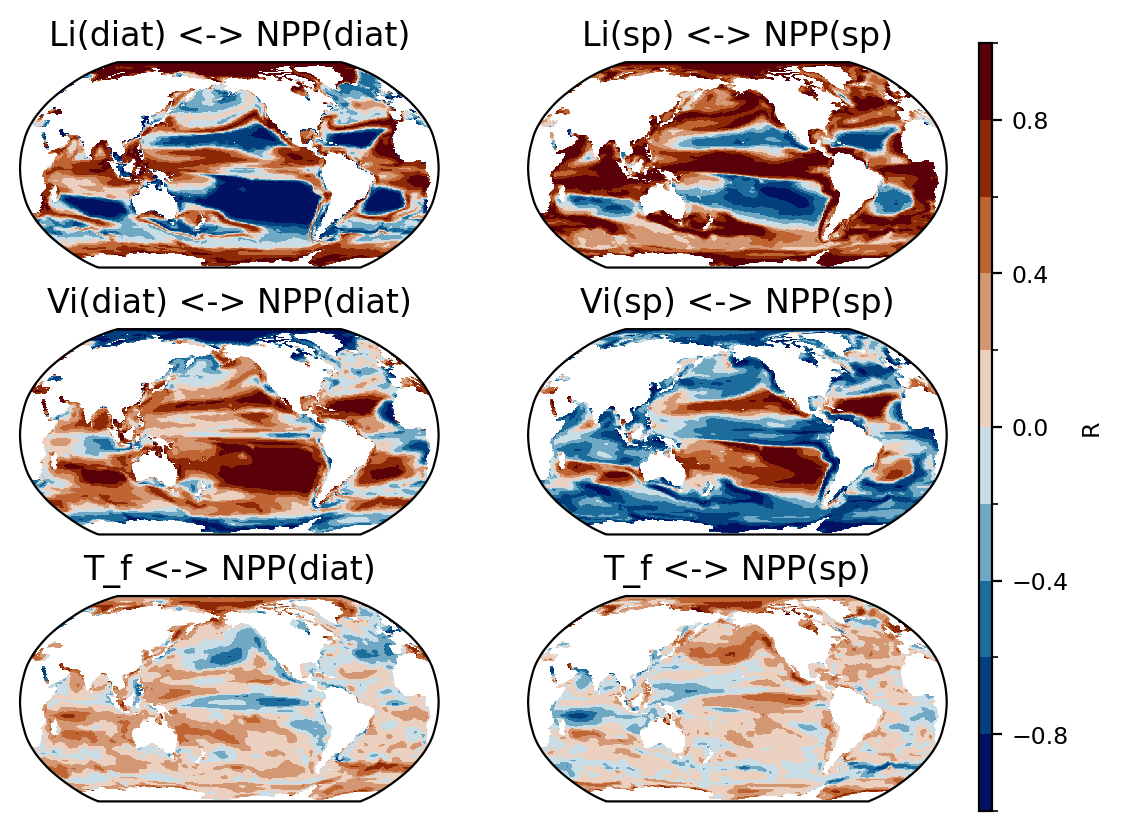

In [15]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18.5, 9), 
#              dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

# # fig1: T_f
# data_array=corr_temp.mean(dim='ens_ODA')
# data_array['TLONG']=ds_grid.TLONG
# data_array['TLAT']=ds_grid.TLAT

# plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
#                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

# axes[2,0].set_title('T_f <-> NPP(TOT)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# fig1: T_f (diat)
data_array=corr_temp_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,0].set_title('T_f <-> NPP(diat)')

# fig1: T_f (diat)
data_array=corr_temp_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,1].set_title('T_f <-> NPP(sp)')


# fig2: Li_diat
data_array=corr_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[0,0].set_title('Li(diat) <-> NPP(diat)')

# fig3: Li_sp
data_array=corr_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[0,1].set_title('Li(sp) <-> NPP(sp)')

# fig4: Vi_diat
data_array=corr_Vi_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[1,0].set_title('Vi(diat) <-> NPP(diat)')

# fig4: Vi_sp
data_array=corr_Vi_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[1,1].set_title('Vi(sp) <-> NPP(sp)')

# axes[2,1].set_visible(False)

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

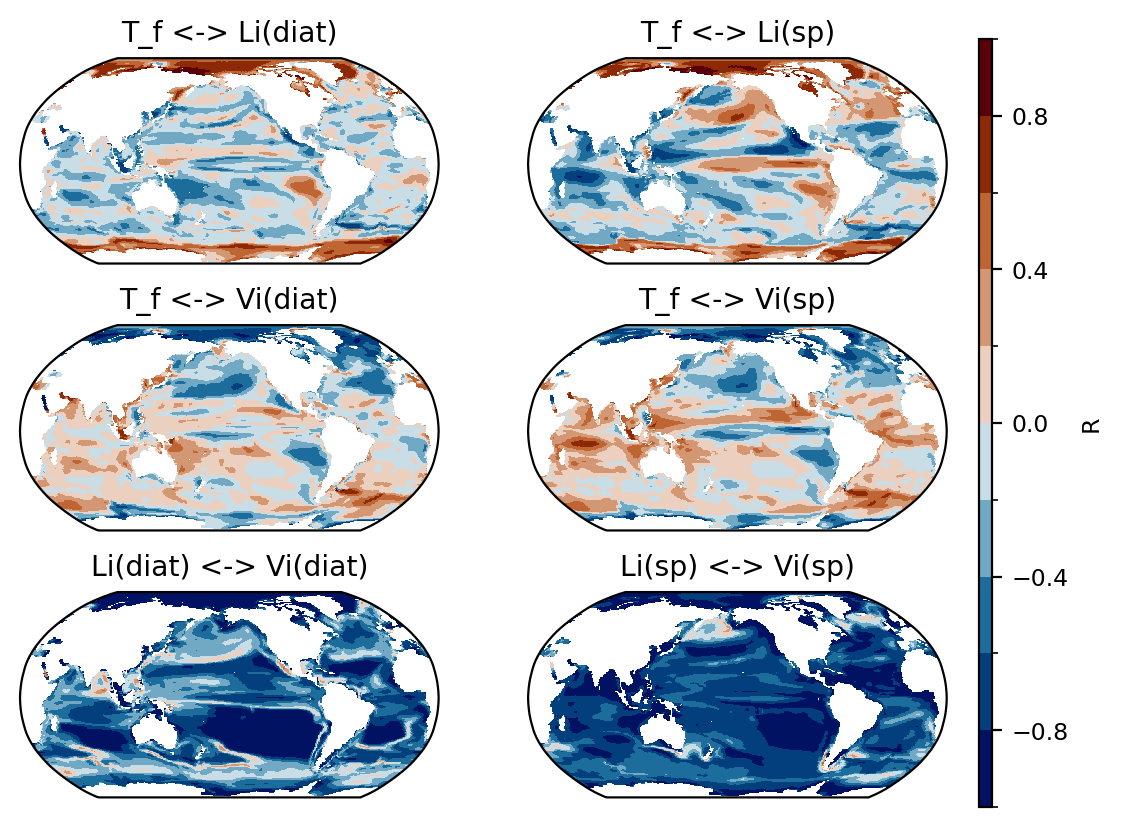

In [16]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18.5, 9), 
#              dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

# # fig1: T_f
# data_array=corr_temp.mean(dim='ens_ODA')
# data_array['TLONG']=ds_grid.TLONG
# data_array['TLAT']=ds_grid.TLAT

# plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
#                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

# axes[2,0].set_title('T_f <-> NPP(TOT)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# fig1: T_f and Li (diat)
data_array=corr_temp_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[0,0].set_title('T_f <-> Li(diat)')

# fig2: T_f and Li (sp)
data_array=corr_temp_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[0,1].set_title('T_f <-> Li(sp)')

# fig3: T_f and Li (diat)
data_array=corr_temp_Vi_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[1,0].set_title('T_f <-> Vi(diat)')

# fig4: T_f and Li (sp)
data_array=corr_temp_Vi_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[1,1].set_title('T_f <-> Vi(sp)')


# fig5: Vi and Li (diat)
data_array=corr_Vi_diat_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,0].set_title('Li(diat) <-> Vi(diat)')

# fig6: Vi and Li (sp)
data_array=corr_Vi_sp_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,1].set_title('Li(sp) <-> Vi(sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

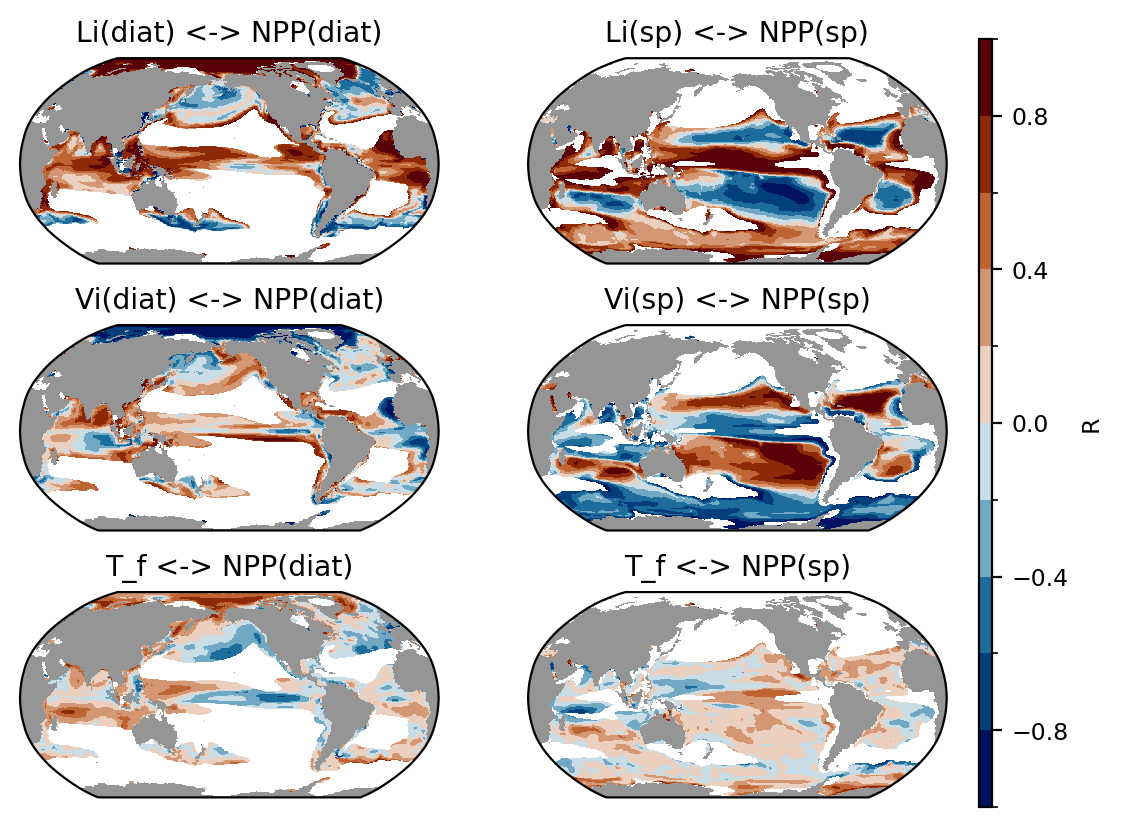

In [17]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)


# fig1: T_f (diat)
data_array=corr_temp_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)


axes[2,0].set_title('T_f <-> NPP(diat)')

# fig2: T_f (diat)
data_array=corr_temp_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land2 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,1].set_title('T_f <-> NPP(sp)')


# fig3: Li_diat
data_array=corr_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land3 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[0,0].set_title('Li(diat) <-> NPP(diat)')

# fig4: Li_sp
data_array=corr_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land4 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[0,1].set_title('Li(sp) <-> NPP(sp)')

# fig5: Vi_diat
data_array=corr_Vi_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt5=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land5 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[1,0].set_title('Vi(diat) <-> NPP(diat)')

# fig6: Vi_sp
data_array=corr_Vi_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt6=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land6 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[1,1].set_title('Vi(sp) <-> NPP(sp)')

# axes[2,1].set_visible(False)

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

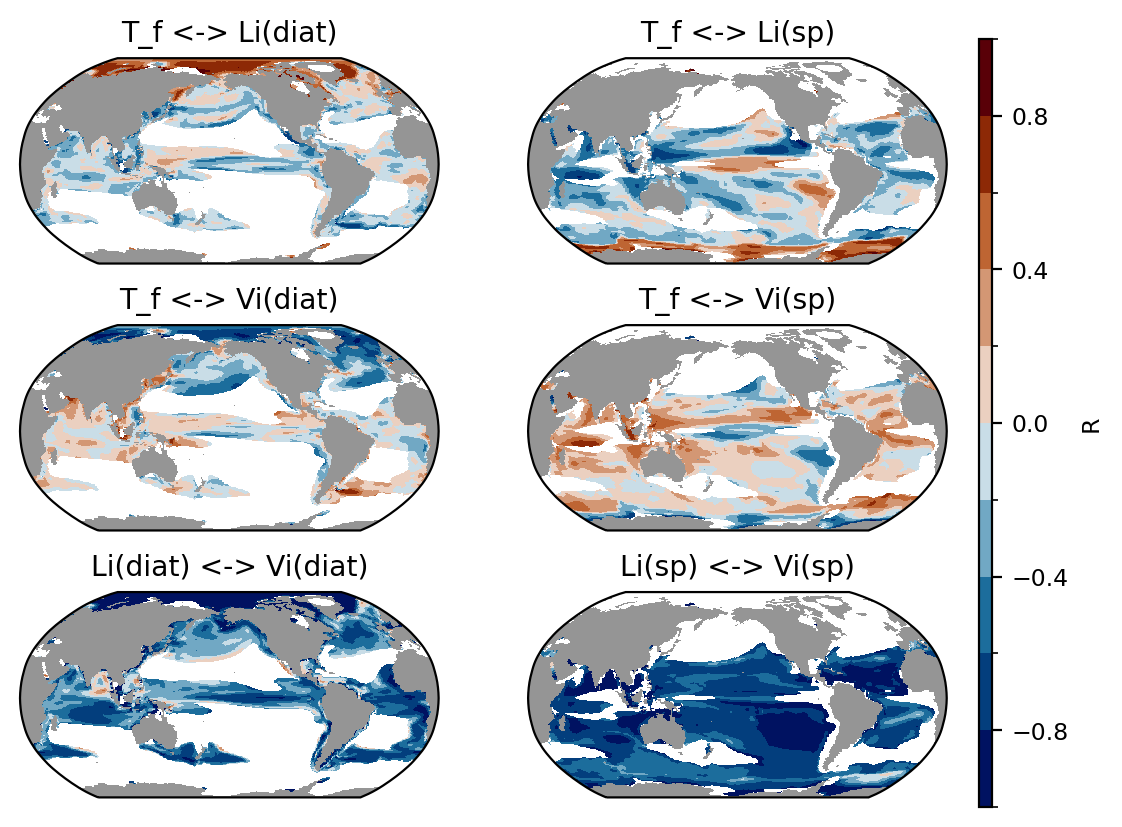

In [18]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: T_f and Li (diat)
data_array=corr_temp_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0,0].set_title('T_f <-> Li(diat)')

# fig2: T_f and Li (sp)
data_array=corr_temp_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land2 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0,1].set_title('T_f <-> Li(sp)')

# fig3: T_f and Li (diat)
data_array=corr_temp_Vi_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land3 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1,0].set_title('T_f <-> Vi(diat)')

# fig4: T_f and Li (sp)
data_array=corr_temp_Vi_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land4 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1,1].set_title('T_f <-> Vi(sp)')


# fig5: Vi and Li (diat)
data_array=corr_Vi_diat_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt5=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land5 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,0].set_title('Li(diat) <-> Vi(diat)')

# fig6: Vi and Li (sp)
data_array=corr_Vi_sp_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt6=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land6 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,1].set_title('Li(sp) <-> Vi(sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

In [19]:
# oda_annual_mean_Vi_diat_index (evaluation by threshold)

start_time = time.time()

def find_majority_value_diat(data, threshold=0.5):
    # 값 1, 2, 3, 4 각각에 대해 year 축을 따라 비율 계산
    counts_1 = (data == 1).sum(dim='year')
    counts_2 = (data == 2).sum(dim='year')
    counts_3 = (data == 3).sum(dim='year')
    counts_4 = (data == 4).sum(dim='year')
    
    # 전체 year 수 (NaN이 아닌 값에 대해서만)
    valid_years = data.notnull().sum(dim='year')

    # 각 값에 대한 비율 계산 (NaN을 제외한 비율)
    ratio_1 = counts_1 / valid_years
    ratio_2 = counts_2 / valid_years
    ratio_3 = counts_3 / valid_years
    ratio_4 = counts_4 / valid_years
    
    # 결과를 저장할 배열을 NaN으로 초기화
    result = xr.full_like(counts_1, np.nan)
    
    # 50% 이상 비율을 차지하는 값을 선택
    result = xr.where(ratio_1 >= threshold, 1, result)
    result = xr.where(ratio_2 >= threshold, 2, result)
    result = xr.where(ratio_3 >= threshold, 3, result)
    result = xr.where(ratio_4 >= threshold, 4, result)

    # 모든 값이 NaN일 경우에는 NaN 유지, 80%를 넘는 값이 없을 경우 5로 설정
    result = xr.where((valid_years > 0) & result.isnull(), 5, result)
    
    return result

# 함수 적용
oda_majority_diat = find_majority_value_diat(oda_annual_mean_Vi_diat_index)
oda_majority_sp = find_majority_value_diat(oda_annual_mean_Vi_sp_index)

end_time = time.time()
elapsed_time = end_time - start_time

In [20]:
# oda_annual_mean_Vi_diat_index (evaluation by most frequent nut)

def find_majority_value_diat(data):
    # 값 1, 2, 3, 4 각각에 대해 year 축을 따라 비율 계산
    counts_1 = (data == 1).sum(dim='year')
    counts_2 = (data == 2).sum(dim='year')
    counts_3 = (data == 3).sum(dim='year')
    counts_4 = (data == 4).sum(dim='year')
    
    # 전체 year 수 (NaN이 아닌 값에 대해서만)
    valid_years = data.notnull().sum(dim='year')

    # 각 값에 대한 비율 계산 (NaN을 제외한 비율)
    ratio_1 = counts_1 / valid_years
    ratio_2 = counts_2 / valid_years
    ratio_3 = counts_3 / valid_years
    ratio_4 = counts_4 / valid_years

    # 비율 중 가장 큰 값을 가지는 인덱스를 찾음
    ratios = xr.concat([ratio_1, ratio_2, ratio_3, ratio_4], dim='value').assign_coords(value=[1, 2, 3, 4])
    max_ratio_value = ratios.idxmax(dim='value')

    # 모든 값이 NaN인 경우 NaN 유지
    result = xr.where(valid_years > 0, max_ratio_value, np.nan)
    
    return result

def find_secondary_value_diat(data):
    # 값 1, 2, 3, 4 각각에 대해 year 축을 따라 비율 계산
    counts_1 = (data == 1).sum(dim='year')
    counts_2 = (data == 2).sum(dim='year')
    counts_3 = (data == 3).sum(dim='year')
    counts_4 = (data == 4).sum(dim='year')
    
    # 전체 year 수 (NaN이 아닌 값에 대해서만)
    valid_years = data.notnull().sum(dim='year')

    # 각 값에 대한 비율 계산 (NaN을 제외한 비율)
    ratio_1 = counts_1 / valid_years
    ratio_2 = counts_2 / valid_years
    ratio_3 = counts_3 / valid_years
    ratio_4 = counts_4 / valid_years

    # 비율 중 가장 큰 값을 가지는 인덱스를 찾음
    ratios = xr.concat([ratio_1, ratio_2, ratio_3, ratio_4], dim='value').assign_coords(value=[1, 2, 3, 4])
    max_ratio_value = ratios.idxmax(dim='value')

    # 가장 큰 값을 제외한 나머지 비율 계산
    masked_ratios = ratios.where(ratios.value != max_ratio_value, other=np.nan)
    
    # 두 번째로 큰 값을 가지는 인덱스 찾기
    secondary_ratio_value = masked_ratios.idxmax(dim='value')

    # 모든 값이 NaN인 경우 NaN 유지
    result = xr.where(valid_years > 0, secondary_ratio_value, np.nan)
    
    return result


# 함수 적용
oda_majority_diat = find_majority_value_diat(oda_annual_mean_Vi_diat_index)
oda_secondary_diat = find_secondary_value_diat(oda_annual_mean_Vi_diat_index)

oda_majority_sp = find_majority_value_diat(oda_annual_mean_Vi_sp_index)
oda_secondary_sp = find_secondary_value_diat(oda_annual_mean_Vi_sp_index)

end_time = time.time()
elapsed_time = end_time - start_time

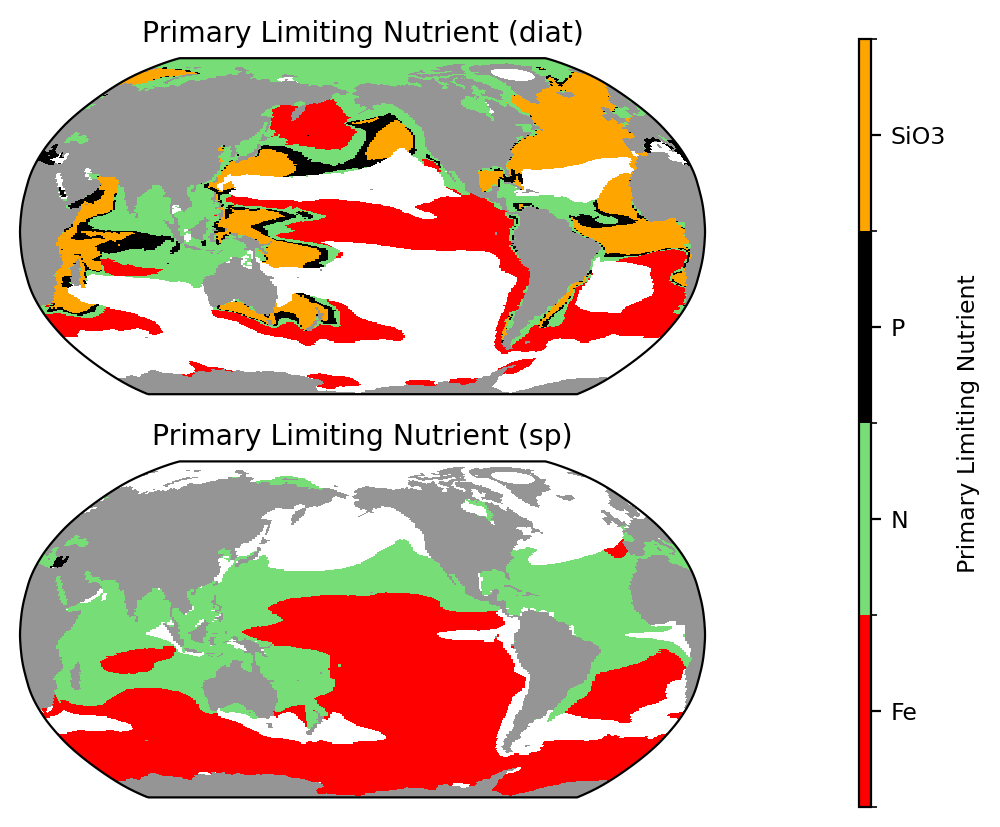

In [21]:

# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


# cmap = cm.vik
# cmap = plt.cm.viridis
# pastel_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']  # Pastel 톤 색상 리스트
# cmap = mcolors.ListedColormap(pastel_colors)
# cmap = plt.get_cmap('Accent')
# cmap = plt.get_cmap('tab10')
colors = ['red', '#77DD77', 'black', 'orange']
cmap = mcolors.ListedColormap(colors)

levels = np.linspace(1, 5, 5) # 1~4, 4 levels Fe, N, P Si, Competition
# levels = np.linspace(1, 5, 6) # 1~5, 5 levels Fe, N, P Si, Competition

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=2, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: Major nutrient (diat)
data_array=oda_majority_diat.where(timstd_NPP_diat['ratio'] >= 0.5).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0].set_title('Primary Limiting Nutrient (diat)')


# fig2: Major nutrient (sp)
data_array=oda_majority_sp.where(timstd_NPP_sp['ratio'] >= 0.5).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1].set_title('Primary Limiting Nutrient (sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('Primary Limiting Nutrient')
cbar1.set_ticks([1.5, 2.5, 3.5, 4.5])  # 각 라벨의 위치를 조정
# cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3', 'Competition'])  # 라벨 변경
cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3'])  # 라벨 변경



plt.show()

end_time = time.time()
elapsed_time = end_time - start_time

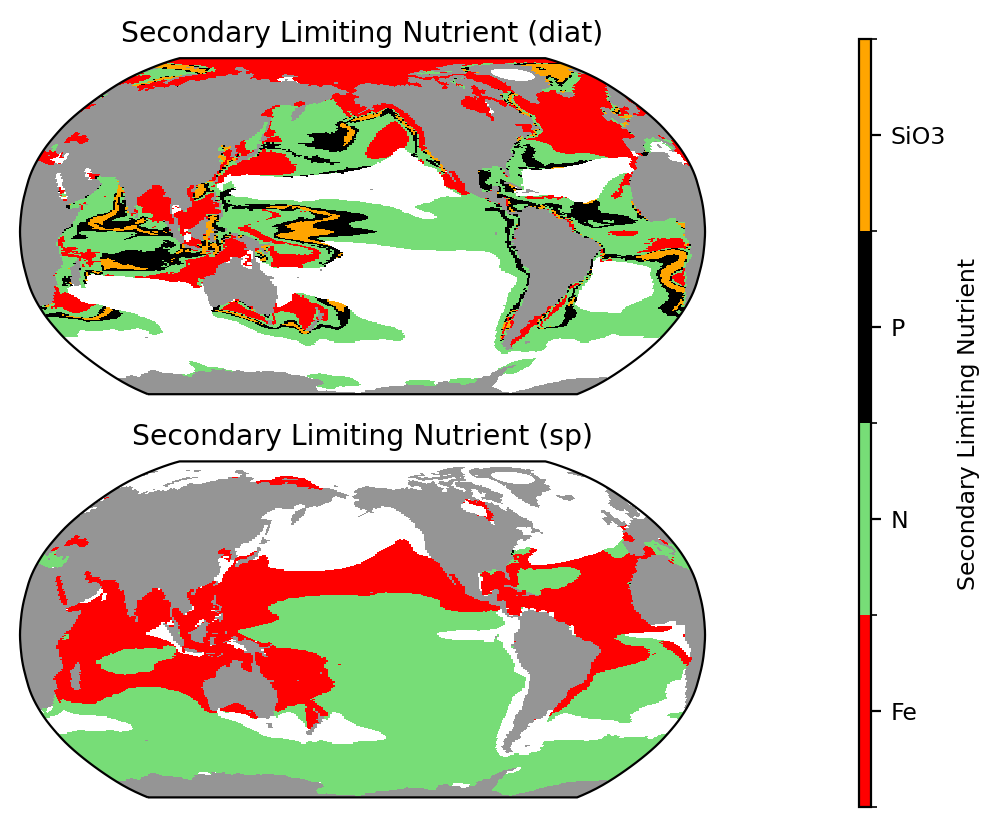

In [22]:

# plot for Secondary limiting nut

start_time = time.time()

varn=cfg_var_NPP_TOT.var #example

if cfg_var_NPP_TOT.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


colors = ['red', '#77DD77', 'black', 'orange']
cmap = mcolors.ListedColormap(colors)

levels = np.linspace(1, 5, 5) # 1~4, 4 levels Fe, N, P Si, Competition

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=2, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: Secondary nutrient (diat)
data_array=oda_secondary_diat.where(timstd_NPP_diat['ratio'] >= 0.5).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0].set_title('Secondary Limiting Nutrient (diat)')


# fig2: Secondary nutrient (sp)
data_array=oda_secondary_sp.where(timstd_NPP_sp['ratio'] >= 0.5).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1].set_title('Secondary Limiting Nutrient (sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('Secondary Limiting Nutrient')
cbar1.set_ticks([1.5, 2.5, 3.5, 4.5])  # 각 라벨의 위치를 조정
# cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3', 'Competition'])  # 라벨 변경
cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3'])  # 라벨 변경



plt.show()

end_time = time.time()
elapsed_time = end_time - start_time